# Correlation between indices and proficiency level
This notebook tries to visualize the correlation between lexcial variation indices and the proficiency level according 
to the CFER.

## 1. Load the dataset
We load each level

In [1]:
dataset_path = '/home/simon/Downloads/efcamdat/'
levels = ['a1','a2','b1','b2','c1']


from DataReader.XMLReader import get_essays
from concurrent.futures import ThreadPoolExecutor, as_completed

texts = []
grades = []

result = {}
with ThreadPoolExecutor(max_workers=4) as executor:
    
    futures_level = {executor.submit(get_essays, dataset_path + 'level_' + level + '.xml'): level for level in levels}
    for future in as_completed(futures_level):
        level = futures_level[future]
        try:
            level_result = future.result()
            result[level] = level_result
        except Exception as exc:
            print('%r generated an exception: %s' % (level, exc))
        
    for level in levels:
        texts += result[level][0]
        grades += result[level][1]

Let's check if we loaded the dataset correctly:

In [2]:
def print_sample_text(text, index):
    print(text + ':')
    print('\t' + texts[index].strip()[0:90] + '...')
    print('\tscore: ' + str(grades[index]))
    
print_sample_text('first a1 essay', 0)
print_sample_text('last a1 essay', 9999)
print_sample_text('first a2 essay', 10000)
print_sample_text('last a2 essay', 19999)
print_sample_text('first c1 essay', 40000)
print_sample_text('last c1 essay', 49999)


first a1 essay:
	In the office there are computer, mouse. There are a lot of pen and pencil. There are a fe...
	score: 95
last a1 essay:
	My name is Armando. I work in Lear.I get up at 6 a.m. I drive to work every days.I get to ...
	score: 90
first a2 essay:
	To: xxx@gamil.com From: xxx@gamil.com Subject: networking event Hi, Amy. I just returned f...
	score: 95
last a2 essay:
	My name is Rui. Im a public servant. My job is easy and very boring. However, I have time ...
	score: 97
first c1 essay:
	I think that every company should build a CSR program. It's not only my opinion, because i...
	score: 95
last c1 essay:
	To my mind, using the technique of Biomass renewable energy would be the most appropriate ...
	score: 95


# 2. Calculate the features
No we pass all texts through the spacy pipeline

In [1]:
from notebook_utils import log_progress
import spacy
from essay_evaluation.pipeline import  FeatureCollector
from Legacy.LexicalDiversity import LexicalVariationFeatures
from essay_evaluation.lexical_variation import features_lv
nlp = spacy.load('en_core_web_sm')
# we only need the tokenizer from spaCy
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')

# add lv features
lv_feature_extractor = LexicalVariationFeatures() 
nlp.add_pipe(lv_feature_extractor, name=lv_feature_extractor.name, last=True)

# add ls features
#ls_feature_extractor = LexicalSophisticationFeatures() 
#nlp.add_pipe(ls_feature_extractor, name=ls_feature_extractor.name, last=True)


# add the feature collector to get a nice feature matrix
feature_collector = FeatureCollector()
nlp.add_pipe(feature_collector, name=feature_collector.name, last=True)


feature_names = features_lv #+ features_ls

docs = []
for doc in log_progress(nlp.pipe(texts),size=len(texts), name='Processed documents'):
    docs.append(doc)

ModuleNotFoundError: No module named 'essay_evaluation.Pipeline'

# 3. Check for correlation

As lables we use the proficiency level. As pearson correlation depens on a numeric value we map the levels to numbers between 0 and 5. So 

A1 -> 1, A2 -> 2, ... , C1 -> 5

In [4]:
import numpy as np
proficiency_levels = [1 for i in range(0,10000)] # text 0-9999 is level a1
proficiency_levels += [2 for i in range(0,10000)] # text 10000 - 19999 is level a2
proficiency_levels += [3 for i in range(0,10000)] # text 20000 - 29999 is level b1
proficiency_levels += [4 for i in range(0,10000)] # text 30000 - 39999 is level b2
proficiency_levels += [5 for i in range(0,10000)] # text 40000 - 49999 is level c1

proficiency_levels_vector = np.array(proficiency_levels)


## 3.1 Plot Histograms
In order to see the structure of our data, we plot a histrogram for each feature:

In [5]:
import math
from matplotlib import pyplot as plt

feature_matrix = np.array(feature_collector.feature_matrix)

rows = math.ceil(len(feature_names)/3)
columns = 3
plt.figure(figsize=(columns*8, rows*6))
for feature_index, feature_column in enumerate(feature_matrix.T):
    plt.subplot(rows,columns,feature_index+1)
    plt.hist2d(feature_column, proficiency_levels_vector, (50, 50), cmap=plt.cm.jet)
    #plt.scatter(feature_column, proficiency_levels_vector)
    plt.title('Histrogram plot (' + feature_names[feature_index] + ' <--> overall score) | Levels ' + ','.join([str(level) for level in levels]))
    plt.xlabel(feature_names[feature_index] + "(index " + str(feature_index)+")")
    plt.ylabel('score')


In [6]:
# helper function to easily plot bar graphs
def plot_correlation(x_values,y_values,x_labels,title):
    plt.figure(figsize=(len(x_values), 10))
    rects = plt.bar(np.arange(len(x_values)),y_values,width=1)

    plt.xticks(np.arange(len(x_values)), x_labels)
    plt.title(title)

    for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    str(round(height,3)),
                    ha='center', va='bottom')


In [7]:
## 3.2 Spearman correlation

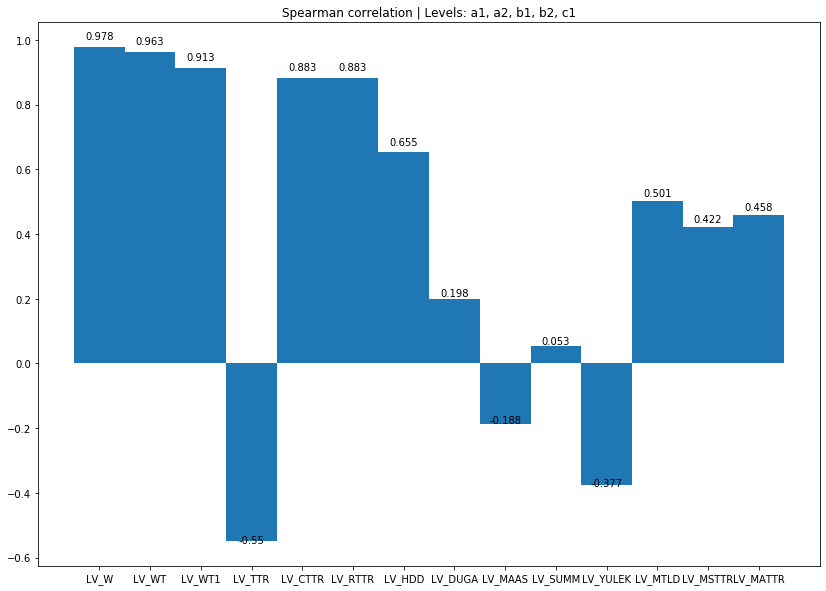

In [8]:
from scipy import stats
correlation_values = []
for feature_column in feature_matrix.T:
    (corr, p_val) = stats.spearmanr(feature_column,proficiency_levels_vector)
    correlation_values.append(corr)

plot_correlation(np.arange(len(feature_names)),correlation_values, feature_names,"Spearman correlation | Levels: " + ', '.join(map(str,levels)))


**Thus we have a very high spearman correlation for several LV features**

## 3.3 Pearson correlation


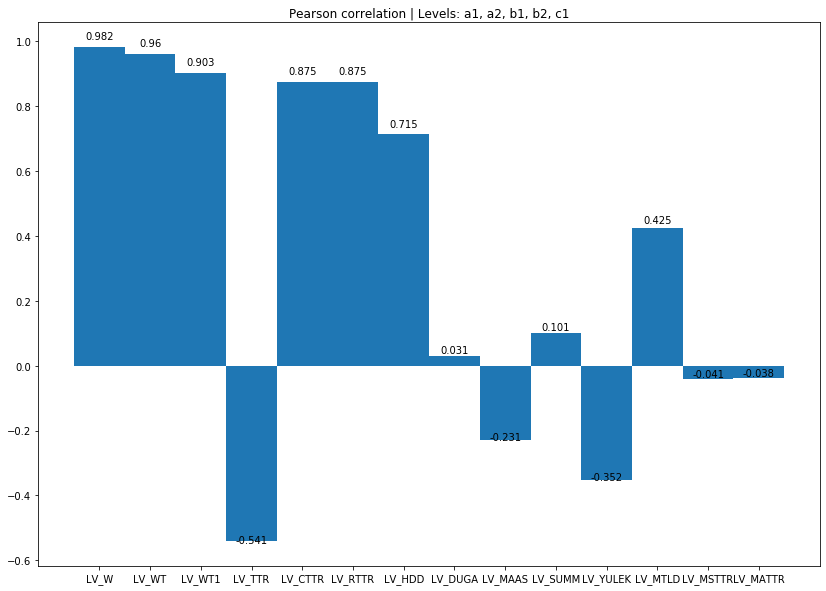

In [10]:
correlation_values = []
for feature_column in feature_matrix.T:
    (corr, p_val) = stats.pearsonr(feature_column,proficiency_levels_vector)
    correlation_values.append(corr)

plot_correlation(np.arange(len(feature_names)),correlation_values, feature_names,"Pearson correlation | Levels: " + ', '.join(map(str,levels)))

**We also get quite high correlation scores here**